In [14]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

# https://github.com/BNL-DAQ-LDRD/calotrack_tree/tree/main
# enum detid {
#     mvtxId = 0,
#     inttId = 1,
#     tpcId = 2,
#     tpotId = 3,
#     cemcId = 4,
#     ihcalId = 5,
#     ohcalId = 6,
#     epdId = 7,
#     mbdId = 8
# };

# input hits in calarometer is "nHits_", and in trackers "reco_cluster_"
# groundtruth hits in calarometer is "particle_" and in trackers "truth_cluster_"
data_file = "../macro/testout.root" # sample data shared by Shuhang containing 100 events
with uproot.open(data_file) as fp:
    print(list(fp['T;1'].keys()))
data = uproot.open(data_file)["T;1"]
detid = {"mvtx": 0,"intt": 1,"tpc": 2,"tpot": 3,"cemc": 4,"ihcal": 5,"ohcal": 6,"epd": 7,"mbd": 8 };
id2det = {x:str(x)+'-'+y for y,x in detid.items()}
## combine all hits and clusters per event
def get_event(event_id):
    calx = data["Hit_x"].array(library="np")[event_id]
    caly = data["Hit_y"].array(library="np")[event_id]
    calz = data["Hit_z"].array(library="np")[event_id]
    calE = data["Hit_E"].array(library="np")[event_id]
    calD = data["Hit_detid"].array(library="np")[event_id]
    trkx = data["reco_cluster_x"].array(library="np")[event_id]
    trky = data["reco_cluster_y"].array(library="np")[event_id]
    trkz = data["reco_cluster_z"].array(library="np")[event_id]
    trkE = data["reco_cluster_E"].array(library="np")[event_id]
    trkD = data["reco_cluster_detid"].array(library="np")[event_id]
    trk_g4hit_trkid = data["reco_cluster_g4hit_trkid"].array(library="np")[event_id]
    x = np.concatenate([trkx])
    y = np.concatenate([trky])
    z = np.concatenate([trkz])
    E = np.concatenate([trkE])
    D = np.concatenate([trkD])
    g4hit_trkid = np.concatenate([trk_g4hit_trkid])
    # x = np.concatenate([trkx, calx])
    # y = np.concatenate([trky, caly])
    # z = np.concatenate([trkz, calz])
    # E = np.concatenate([trkE, calE])
    # D = np.concatenate([trkD, calD])
    df = pd.DataFrame({"x": x, "y": y, "z": z, "E": E, "D": D, "g4hit_trkid": g4hit_trkid})
    df["detector type"] = df["D"].apply(lambda x: id2det[x])
    df = df[(df['g4hit_trkid'] < 100)]
    return df
event_id = 0  # pick different events

## Pie Chart of number of "hits" and "clusters" from different detectors
df = get_event(event_id)
tmp = df["detector type"].to_list();
a, b= np.unique(tmp, return_counts=True)
tmp_df = pd.DataFrame({'name': a, 'count': b})
fig = px.pie(tmp_df, values='count', names='name')
fig.update_layout(legend_traceorder="normal")
fig.show()

## Interactive 3D Scatter. 
## try: single click or double click the detector type in the legend.
fig = px.scatter_3d(df, x='x', y='y', z='z', color='g4hit_trkid', opacity=0.3)#, symbol='D')
fig.update_traces(marker_size=3)
fig.update_layout(title=f"event {event_id}", width=800, height=800)
camera = dict(
    up=dict(x=1, y=0, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)
fig.update_layout(scene_camera=camera, title=f"EventID={event_id}")
fig.update_layout(legend_traceorder="normal")
fig.show()


['b', 'b_phi', 'Ncoll', 'Ncoll_hard', 'Npart_proj', 'Npart_targ', 'centile', 'runnumber', 'evtnumber', 'filename', 'nHits', 'Hit_E', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_detid', 'nParticles', 'particle_pid', 'particle_energy', 'particle_px', 'particle_py', 'particle_pz', 'particle_vtx_x', 'particle_vtx_y', 'particle_vtx_z', 'particle_track_id', 'particle_primary_id', 'particle_parent_id', 'particle_is_pythia_primary', 'particle_is_embedded', 'particle_charge', 'nRecoClusters', 'reco_cluster_E', 'reco_cluster_x', 'reco_cluster_y', 'reco_cluster_z', 'reco_cluster_t', 'reco_cluster_detid', 'reco_cluster_id', 'reco_cluster_trcluster_id', 'reco_cluster_g4hit_id', 'reco_cluster_g4hit_trkid', 'nTruthClusters', 'truth_cluster_E', 'truth_cluster_x', 'truth_cluster_y', 'truth_cluster_z', 'truth_cluster_t', 'truth_cluster_detid', 'truth_cluster_id', 'truth_cluster_trparticle_track_id', 'nTrackG4Hits', 'track_g4hit_x', 'track_g4hit_y', 'track_g4hit_z', 'track_g4hit_t', 'track_g4hit_E', 'track_

Number of clusters: 158526
(4, [14087492730890, 299960515952653, 585970978127874, 73352818735448095, 73994933526069253, 146097611835703419, 146379086812414023, 146660561789124699, 146942036765835322, 147223511742546036, 147504986719256615, 147786461695967338, 148067936672678034, 148349411649388663, 148630886626099320, 149475311556231266, 150038261509652580, 150319736486363159, 150601211463073830, 150881586928156682, 151163061904867366, 151444536881578028, 151444536881578054, 151726011858288672, 152007486834999342, 152288961811709967, 152288961811710023, 152570436788420687, 153133386741841988, 153414861718552614, 153696336695263295, 153977811671973933, 154259286648684599, 154540761625395243, 154822236602105929, 154822236602105964, 155103711578816542, 155103711578816581, 155385186555527188, 155666661532237899, 155666661532237941, 155948136508948493, 156229611485659180, 156511086462369851, 156511086462369888, 156792561439080511, 157074036415791153, 157074036415791182, 157355511392501824, 

(-100000000.0, 100000000.0)

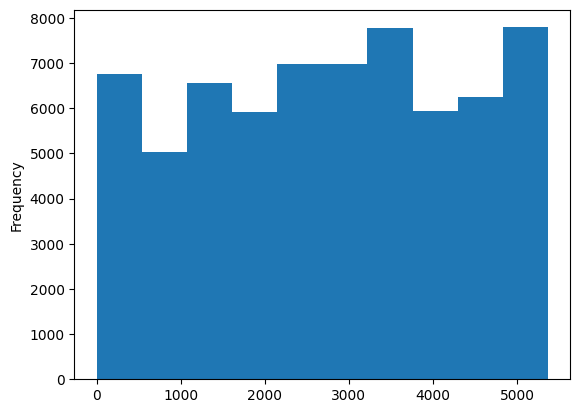

In [39]:
def get_clusters(data, event_id):
    cid = data["reco_cluster_id"].array(library="np")[event_id]
    x = data["reco_cluster_x"].array(library="np")[event_id]
    y = data["reco_cluster_y"].array(library="np")[event_id]
    z = data["reco_cluster_z"].array(library="np")[event_id]
    detid = data["reco_cluster_detid"].array(library="np")[event_id]
    pid = data["reco_cluster_g4hit_trkid"].array(library="np")[event_id]
    df = pd.DataFrame({"cid": cid, "x": x, "y": y, "z": z, "detid": detid, "pid": pid})
    return df

clusters = get_clusters(data, 0)
cid_to_index = {cid: index for index, cid in enumerate(clusters['cid'])}
pid_to_cids = clusters.groupby('pid')['cid'].apply(list).to_dict()

print(f"Number of clusters: {len(clusters)}")
print(list(pid_to_cids.items())[0])
for i in range(10):
    print(list(pid_to_cids.items())[i])

clusters[clusters["pid"] < 1e8]["pid"].plot(kind="hist")
ax.set_xlim(-1e8, 1e8)


In [40]:
def get_seeds(data, event_id):
    sid = data["tpc_seeds_id"].array(library="np")[event_id]
    cids = data["tpc_seeds_clusters"].array(library="np")[event_id]
    ncid = data["tpc_seeds_nclusters"].array(library="np")[event_id]
    cid_start = data["tpc_seeds_start_idx"].array(library="np")[event_id]
    list_of_cids = [cids[start : start + length] 
                for start, length in zip(cid_start, ncid)]
    lists_of_x = [[clusters.iloc[cid_to_index[cid]]['x'] for cid in cids] for cids in list_of_cids]
    lists_of_y = [[clusters.iloc[cid_to_index[cid]]['y'] for cid in cids] for cids in list_of_cids]
    lists_of_z = [[clusters.iloc[cid_to_index[cid]]['z'] for cid in cids] for cids in list_of_cids]
    df = pd.DataFrame({"sid": sid, "cids": list_of_cids, "x": lists_of_x, "y": lists_of_y, "z": lists_of_z})
    return df

seeds = get_seeds(data, 0)
print(f"Number of seeds: {len(seeds)}")
print(seeds.iloc[0])

Number of seeds: 1517
sid                                                     0
cids    [157625986957967459, 157907461934678125, 15818...
x       [-51.167686462402344, -51.70665740966797, -52....
y       [45.9769287109375, 47.02622604370117, 48.19799...
z       [-14.30121898651123, -14.39283561706543, -14.8...
Name: 0, dtype: object


Number of particles: 58
pt: 1.142695713284946, cids: 42
pt: 1.391018633510138, cids: 44
pt: 1.0244510539322114, cids: 45
pt: 1.6175212209440348, cids: 47
pt: 1.3328012367482784, cids: 37
pt: 1.2948651826368531, cids: 37
pt: 1.1510588168228784, cids: 41
pt: 1.7035205659794268, cids: 36
pt: 1.5776481466128474, cids: 37
pt: 1.703615979387868, cids: 44


<Axes: ylabel='Frequency'>

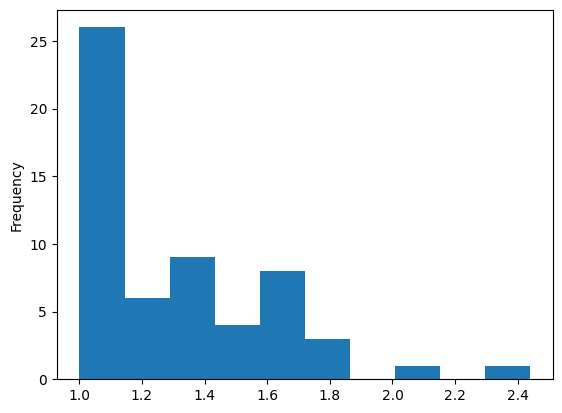

In [61]:
def get_particles(data, event_id):
    pid = data["particle_track_id"].array(library="np")[event_id]
    cids = [pid_to_cids.get(p, [])  for p in pid]
    px = data["particle_px"].array(library="np")[event_id]
    py = data["particle_py"].array(library="np")[event_id]
    pz = data["particle_pz"].array(library="np")[event_id]
    pt = [np.sqrt(px**2 + py**2) for px, py in zip(px, py)]
    df = pd.DataFrame({"pid": pid, "pt": pt, "cids": cids})
    df = df[df['pid'] > 0]
    df = df[df['pt'] > 1]
    df = df[df['cids'].apply(len) > 30]
    return df
particles = get_particles(data, 0)

print(f"Number of particles: {len(particles)}")
for i in range(10):
    print(f"pt: {particles.iloc[i]['pt']}, cids: {len(particles['cids'].iloc[i])}")

particles['pt'].plot(kind='hist')




In [53]:
import pandas as pd
import plotly.express as px

# Flatten the lists in seeds DataFrame so that each row is one cluster point,
# and include the seed id for grouping.
flattened_data = {"seed": [], "x": [], "y": [], "z": []}
for _, row in seeds.iterrows():
    for x_val, y_val, z_val in zip(row["x"], row["y"], row["z"]):
        if row["sid"] % 100 != 0:
            continue
        flattened_data["seed"].append(row["sid"])
        flattened_data["x"].append(x_val)
        flattened_data["y"].append(y_val)
        flattened_data["z"].append(z_val)

df_flat = pd.DataFrame(flattened_data)

# Create a 3D scatter plot using Plotly Express
fig = px.scatter_3d(
    df_flat,
    x="x",
    y="y",
    z="z",
    color="seed",
    title="3D Scatter Plot of Seed Clusters"
)
fig.update_traces(marker_size=3)
fig.update_layout(scene_camera=dict(
    eye=dict(x=0, y=0, z=2)
))
fig.show()


All 58 matched: 34


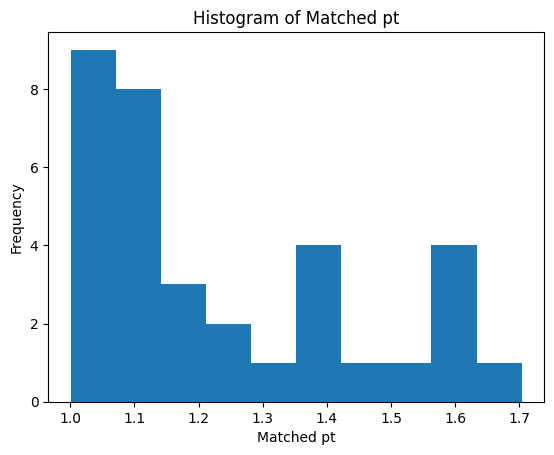

In [59]:
def match_particles_to_seeds(particles, seeds, ncommon):
    """
    For each particle in the particles DataFrame, find seeds in the seeds DataFrame
    that share at least `ncommon` common cids.

    Parameters:
        particles (pd.DataFrame): DataFrame with at least columns 'pid' and 'cids'.
        seeds (pd.DataFrame): DataFrame with at least columns 'sid' and 'cids'.
        ncommon (int): Minimum number of common cids required for a match.

    Returns:
        dict: A dictionary mapping each particle's pid to a list of seed sids that match.
    """
    matched_pt = []
    for _, particle in particles.iterrows():
        particle_pid = particle['pid']
        # Convert the list of cids to a set for efficient intersection
        particle_cids = set(particle['cids'])
        for _, seed in seeds.iterrows():
            seed_sid = seed['sid']
            seed_cids = set(seed['cids'])
            # Calculate the number of common cids between the particle and the seed
            if len(particle_cids.intersection(seed_cids)) >= ncommon:
                matched_pt.append(particle['pt'])
                break
    return matched_pt

# Example usage:
# Assuming `particles` and `seeds` are already defined from get_particles() and get_seeds():
ncommon = 6  # change to your desired threshold
matched_pt = match_particles_to_seeds(particles, seeds, ncommon)
print(f"All {len(particles)} matched: {len(matched_pt)}")

plt.hist(matched_pt, bins=10)
plt.xlabel('Matched pt')
plt.ylabel('Frequency')
plt.title('Histogram of Matched pt')
plt.show()